## Burger's Equation

### (1) Problem Description
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t)=0,\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### (2) The Deep Generative Neural Operator (DGNO)
[DGenNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

### (2.1) Prepare data

The shape of x_train: torch.Size([1000, 128, 1])
The shape of a_train: torch.Size([1000, 128, 1])
The shape of gridxt_train: torch.Size([12928, 2])
The shape of x_test: torch.Size([200, 128, 1])
The shape of a_test: torch.Size([200, 128, 1])
The shape of u_test: torch.Size([200, 12928, 1])
The shape of uT_train: torch.Size([200, 128, 1])
The shape of gridxt_test: torch.Size([12928, 2])
************************************
The shape of xt_init: torch.Size([128, 2])
The shape of xt_end: torch.Size([128, 2])


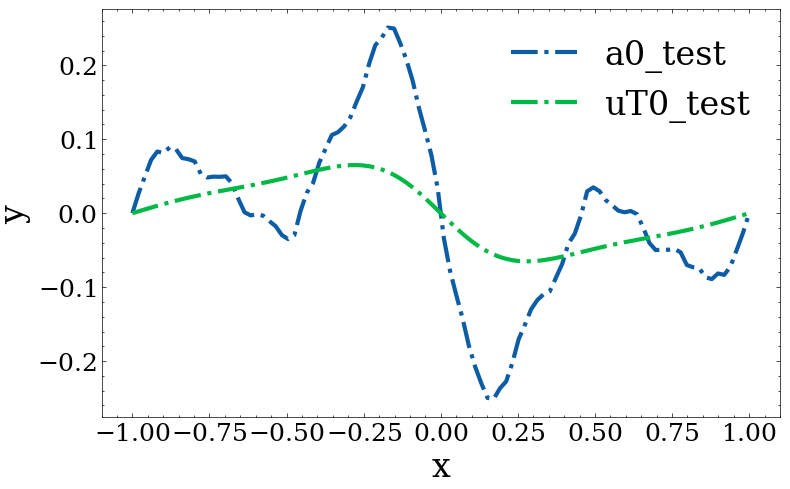

In [1]:
import sys 
sys.path.append("..")
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086 
setup_seed(random_seed)
device = 'cuda:1'
dtype = torch.float32

######################################
# Load training and testing data
######################################
from Utils.utils import *
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["u0"]).T, dtype)
    u = np2tensor(np.array(data["u_sol"]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np.array(data['x_mesh']).T
    t_mesh = np.array(data['t_mesh']).T
    X, T = np.meshgrid(x_mesh, t_mesh)
    mesh = np2tensor(np.vstack([X.ravel(), T.ravel()]).T, dtype)
    grid_xt = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    x = np2tensor(x_mesh).reshape(1, -1, 1).repeat(ndata,1,1)
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, u, uT, x, grid_xt
#
data_train = h5py.File('./dataset/viscid_train.mat', 'r')
data_test = h5py.File('./dataset/viscid_test_in.mat', 'r')
a_train, u_train, uT_train, x_train, gridxt_train = get_data(data_train, dtype)
a_test, u_test, uT_test, x_test, gridxt_test = get_data(data_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of gridxt_train:', gridxt_train.shape)
#
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridxt_test:', gridxt_test.shape)

###################################### initial points
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
xt_init = pointGen.init_point(num_sample=a_test.shape[1], t_stamp=[0.], method='mesh')
xt_end = pointGen.init_point(num_sample=uT_test.shape[1], t_stamp=[1.], method='mesh')
print('************************************')
print('The shape of xt_init:', xt_init.shape)
print('The shape of xt_end:', xt_end.shape)

########################################
from Utils.PlotFigure import Plot
inx = 0
Plot.show_1d_list(x_test[inx], [a_test[inx], uT_test[inx]], ['a0_test', 'uT0_test'], lb =-1.)

### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifier(object):

    def __inint__(self):
        super(mollifier, self).__init_()
        
    def __call__(self, u, xt):
        '''The mollifer
        Input:
            u: size(n_batch, mesh_size)
            xt: size(n_batch, mesh_size, 2)
        Output:
            u: size(n_batch, mesh_size, 1)
        '''
        x= xt[...,0]
        u = u * torch.sin(np.pi*x/2. + np.pi/2.)
        return u.unsqueeze(-1)

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.mollifier = mollifier()
        ######################## 
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        
    def Loss_pde(self, a_batch, nc=100, lamda=0.1/torch.pi):
        ''' 
        Input:
            a_batch: size(n_batch, n_mesh, in_channel)
        '''
        beta = self.model_enc(a_batch)
        n_batch = a_batch.shape[0]
        # ################################## 
        # # # xc:size(nc, 1, 1), tc:size(nc, 1, 1) R:size(nc, 1, 1)
        xc, tc, R = pointGen.weight_centers(n_center=1, nt=nc, Rmax=1e-4, Rmin=1e-4, method='hypercube')
        xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 1) -> (nc*n_grid, 1)
        x = (self.int_grid * R + xc).reshape(-1, 1)
        t = tc.repeat(1, self.n_grid, 1).reshape(-1, 1)
        # size(nc*n_grid, 1) -> (n_batch, nc*n_grid, 2)
        x = Variable(x.repeat((n_batch,1,1)), requires_grad=True) 
        t = Variable(t.repeat((n_batch,1,1)), requires_grad=True)  
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1,1)
        ##########################################
        u = self.model_u(xt, beta)
        u = self.mollifier(u, xt)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=xt, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        dux, dut = du[...,0:1], du[...,1:2]
        ########################################### weawk residual
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        res0 = dut*v + u * dux * v + lamda * dux * dv
        res0 = torch.mean(res0.reshape(n_batch, nc, self.n_grid), dim=-1)
        ################################################
        res_sq = (res0)**2
        res_sq, indices = torch.sort(res_sq.flatten(), descending=True, dim=0)

        return self.solver.getLoss(res0, torch.zeros_like(res0)) + torch.sum( res_sq[0:100*25] )  

    def Loss_data(self, x, a, u):
        '''Note: u is not used for training
        '''
        n_batch = a.shape[0]
        beta = self.model_enc(a)
        ############### The initial condition
        xt = xt_init.repeat(n_batch, 1, 1).to(self.device)
        u_init = self.model_u(xt, beta)
        u_init = self.mollifier(u_init, xt)
        #
        loss_init = self.solver.getLoss(u_init, a)
        
        return loss_init
        
    def Error(self, x, a, u):
        '''
        '''
        n_batch = a.shape[0]
        beta = self.model_enc(a)
        ##################
        xt = gridxt_test.repeat(n_batch, 1, 1).to(self.device)
        u_pred = self.model_u(xt, beta)
        u_pred = self.mollifier(u_pred, xt)
        #
        error = self.solver.getError(u_pred, u)

        return error

######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' 
beta_size = 128   
hidden_size = 100

# ####################################### The Encoder
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, feat):
        beta = self.encoder(feat)
        beta = nn.Tanh()(beta)
        return beta
#
layers_beta = [a_train.shape[1], 256, 128, 64, beta_size]
model_enc = Encoder(layers_beta, act_beta='SiLU', dtype=dtype).to(device)

###################################### The Decoder
trunk_layers, branch_layers = [hidden_size]*6, [hidden_size]*6
model_u = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='SiLU_Id',
                           netType=netType, sum_layers=5)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

The shape of int_grid torch.Size([10, 1]) The shape of phi: torch.Size([10, 1])
82,496 training parameters.
114,206 training parameters.
196,702 total parameters


### (2.3) training the model

In [3]:
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=1/3, step_size=np.int32(10000/5))
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=10000, w_pde=1000., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_latent{beta_size}/'})

  0%|▍                                                                           | 50/10000 [00:20<1:07:38,  2.45it/s]

Epoch:50 Time:20.8630, loss:5555.9336, loss_pde:0.1679, loss_data:0.5388
                l2_test:0.1976, lr:0.001


  1%|▊                                                                          | 100/10000 [00:41<1:06:30,  2.48it/s]

Epoch:100 Time:41.1689, loss:4258.9070, loss_pde:0.1276, loss_data:0.4131
                l2_test:0.1236, lr:0.001


  2%|█▏                                                                         | 150/10000 [01:01<1:07:14,  2.44it/s]

Epoch:150 Time:61.4939, loss:3321.6598, loss_pde:0.1338, loss_data:0.3188
                l2_test:0.0869, lr:0.001


  2%|█▌                                                                         | 200/10000 [01:21<1:05:28,  2.49it/s]

Epoch:200 Time:81.6799, loss:2838.3238, loss_pde:0.2098, loss_data:0.2629
                l2_test:0.0748, lr:0.001


  2%|█▉                                                                         | 250/10000 [01:41<1:04:54,  2.50it/s]

Epoch:250 Time:101.6866, loss:2692.6344, loss_pde:0.1480, loss_data:0.2545
                l2_test:0.0801, lr:0.001


  3%|██▎                                                                        | 300/10000 [02:01<1:05:59,  2.45it/s]

Epoch:300 Time:121.8578, loss:2638.7967, loss_pde:0.1215, loss_data:0.2517
                l2_test:0.0742, lr:0.001


  4%|██▋                                                                        | 350/10000 [02:22<1:06:03,  2.43it/s]

Epoch:350 Time:142.3010, loss:2366.9590, loss_pde:0.1905, loss_data:0.2176
                l2_test:0.0631, lr:0.001


  4%|███                                                                        | 400/10000 [02:42<1:05:53,  2.43it/s]

Epoch:400 Time:162.8048, loss:2243.1719, loss_pde:0.1280, loss_data:0.2115
                l2_test:0.0631, lr:0.001


  4%|███▍                                                                       | 450/10000 [03:03<1:04:57,  2.45it/s]

Epoch:450 Time:183.2530, loss:2098.9557, loss_pde:0.2024, loss_data:0.1897
                l2_test:0.0721, lr:0.001


  5%|███▊                                                                       | 500/10000 [03:23<1:04:56,  2.44it/s]

Epoch:500 Time:203.7305, loss:1984.9648, loss_pde:0.1636, loss_data:0.1821
                l2_test:0.0583, lr:0.001


  6%|████▏                                                                      | 550/10000 [03:44<1:04:17,  2.45it/s]

Epoch:550 Time:224.1879, loss:1986.9656, loss_pde:0.1593, loss_data:0.1828
                l2_test:0.0731, lr:0.001


  6%|████▌                                                                      | 600/10000 [04:04<1:04:18,  2.44it/s]

Epoch:600 Time:244.6379, loss:1955.1020, loss_pde:0.1818, loss_data:0.1773
                l2_test:0.0549, lr:0.001


  6%|████▉                                                                      | 650/10000 [04:25<1:04:09,  2.43it/s]

Epoch:650 Time:265.1091, loss:1794.2064, loss_pde:0.1862, loss_data:0.1608
                l2_test:0.0504, lr:0.001


  7%|█████▎                                                                     | 700/10000 [04:45<1:03:20,  2.45it/s]

Epoch:700 Time:285.5663, loss:1740.0945, loss_pde:0.1488, loss_data:0.1591
                l2_test:0.0512, lr:0.001


  8%|█████▋                                                                     | 750/10000 [05:05<1:02:10,  2.48it/s]

Epoch:750 Time:305.9068, loss:1628.0809, loss_pde:0.1841, loss_data:0.1444
                l2_test:0.0498, lr:0.001


  8%|██████                                                                     | 800/10000 [05:26<1:02:53,  2.44it/s]

Epoch:800 Time:326.4012, loss:1497.9541, loss_pde:0.1414, loss_data:0.1357
                l2_test:0.0437, lr:0.001


  8%|██████▍                                                                    | 850/10000 [05:46<1:02:40,  2.43it/s]

Epoch:850 Time:346.8393, loss:1630.3979, loss_pde:0.1878, loss_data:0.1443
                l2_test:0.0654, lr:0.001


  9%|██████▊                                                                    | 900/10000 [06:07<1:02:03,  2.44it/s]

Epoch:900 Time:367.1920, loss:1560.0822, loss_pde:0.1920, loss_data:0.1368
                l2_test:0.0494, lr:0.001


 10%|███████▏                                                                   | 950/10000 [06:27<1:01:38,  2.45it/s]

Epoch:950 Time:387.5762, loss:1470.0723, loss_pde:0.1847, loss_data:0.1285
                l2_test:0.0477, lr:0.001


 10%|███████▌                                                                    | 1000/10000 [06:47<59:54,  2.50it/s]

Epoch:1000 Time:407.6036, loss:1500.7971, loss_pde:0.1821, loss_data:0.1319
                l2_test:0.0530, lr:0.001


 10%|███████▊                                                                  | 1050/10000 [07:08<1:01:13,  2.44it/s]

Epoch:1050 Time:428.0296, loss:1484.8544, loss_pde:0.1932, loss_data:0.1292
                l2_test:0.0484, lr:0.001


 11%|████████▎                                                                   | 1100/10000 [07:28<59:22,  2.50it/s]

Epoch:1100 Time:448.2698, loss:1371.3541, loss_pde:0.1354, loss_data:0.1236
                l2_test:0.0449, lr:0.001


 12%|████████▌                                                                 | 1150/10000 [07:48<1:00:23,  2.44it/s]

Epoch:1150 Time:468.6204, loss:1393.1815, loss_pde:0.1912, loss_data:0.1202
                l2_test:0.0483, lr:0.001


 12%|████████▉                                                                 | 1200/10000 [08:09<1:00:03,  2.44it/s]

Epoch:1200 Time:489.0756, loss:1419.1028, loss_pde:0.2107, loss_data:0.1208
                l2_test:0.0524, lr:0.001


 12%|█████████▌                                                                  | 1250/10000 [08:29<59:44,  2.44it/s]

Epoch:1250 Time:509.5610, loss:1437.5240, loss_pde:0.2248, loss_data:0.1213
                l2_test:0.0496, lr:0.001


 13%|█████████▉                                                                  | 1300/10000 [08:50<59:17,  2.45it/s]

Epoch:1300 Time:530.0345, loss:1280.4142, loss_pde:0.1608, loss_data:0.1120
                l2_test:0.0433, lr:0.001


 14%|██████████▎                                                                 | 1350/10000 [09:10<59:12,  2.43it/s]

Epoch:1350 Time:550.5197, loss:1254.6853, loss_pde:0.1410, loss_data:0.1114
                l2_test:0.0436, lr:0.001


 14%|██████████▋                                                                 | 1400/10000 [09:30<58:47,  2.44it/s]

Epoch:1400 Time:570.9926, loss:1430.6965, loss_pde:0.2387, loss_data:0.1192
                l2_test:0.0591, lr:0.001


 14%|███████████                                                                 | 1450/10000 [09:51<58:26,  2.44it/s]

Epoch:1450 Time:591.4848, loss:1295.8336, loss_pde:0.1763, loss_data:0.1120
                l2_test:0.0451, lr:0.001


 15%|███████████▍                                                                | 1500/10000 [10:11<57:56,  2.45it/s]

Epoch:1500 Time:611.9570, loss:1365.9488, loss_pde:0.2280, loss_data:0.1138
                l2_test:0.0489, lr:0.001


 16%|███████████▊                                                                | 1550/10000 [10:32<58:02,  2.43it/s]

Epoch:1550 Time:632.4173, loss:1243.6072, loss_pde:0.1758, loss_data:0.1068
                l2_test:0.0458, lr:0.001


 16%|████████████▏                                                               | 1600/10000 [10:52<57:18,  2.44it/s]

Epoch:1600 Time:652.9208, loss:1239.5526, loss_pde:0.1801, loss_data:0.1060
                l2_test:0.0464, lr:0.001


 16%|████████████▌                                                               | 1650/10000 [11:13<56:43,  2.45it/s]

Epoch:1650 Time:673.4025, loss:1344.1528, loss_pde:0.2078, loss_data:0.1136
                l2_test:0.0433, lr:0.001


 17%|████████████▉                                                               | 1700/10000 [11:33<56:42,  2.44it/s]

Epoch:1700 Time:693.8510, loss:1249.4949, loss_pde:0.2103, loss_data:0.1039
                l2_test:0.0412, lr:0.001


 18%|█████████████▎                                                              | 1750/10000 [11:54<56:17,  2.44it/s]

Epoch:1750 Time:714.3155, loss:1186.8253, loss_pde:0.1917, loss_data:0.0995
                l2_test:0.0407, lr:0.001


 18%|█████████████▋                                                              | 1800/10000 [12:14<55:46,  2.45it/s]

Epoch:1800 Time:734.7605, loss:1254.7909, loss_pde:0.2046, loss_data:0.1050
                l2_test:0.0407, lr:0.001


 18%|██████████████                                                              | 1850/10000 [12:35<55:31,  2.45it/s]

Epoch:1850 Time:755.2250, loss:1171.5963, loss_pde:0.1818, loss_data:0.0990
                l2_test:0.0441, lr:0.001


 19%|██████████████▍                                                             | 1900/10000 [12:55<55:12,  2.45it/s]

Epoch:1900 Time:775.6930, loss:1253.2783, loss_pde:0.1832, loss_data:0.1070
                l2_test:0.0414, lr:0.001


 20%|██████████████▊                                                             | 1950/10000 [13:15<53:33,  2.51it/s]

Epoch:1950 Time:795.7360, loss:1203.1574, loss_pde:0.2018, loss_data:0.1001
                l2_test:0.0487, lr:0.001


 20%|███████████████▏                                                            | 2000/10000 [13:36<54:35,  2.44it/s]

Epoch:2000 Time:816.0681, loss:1131.0774, loss_pde:0.1669, loss_data:0.0964
                l2_test:0.0399, lr:0.0003333333333333333


 20%|███████████████▌                                                            | 2050/10000 [13:56<54:38,  2.42it/s]

Epoch:2050 Time:836.5859, loss:880.1463, loss_pde:0.0681, loss_data:0.0812
                l2_test:0.0220, lr:0.0003333333333333333


 21%|███████████████▉                                                            | 2100/10000 [14:17<53:46,  2.45it/s]

Epoch:2100 Time:857.0428, loss:890.6005, loss_pde:0.0744, loss_data:0.0816
                l2_test:0.0244, lr:0.0003333333333333333


 22%|████████████████▎                                                           | 2150/10000 [14:37<52:52,  2.47it/s]

Epoch:2150 Time:877.2328, loss:859.9040, loss_pde:0.0834, loss_data:0.0776
                l2_test:0.0242, lr:0.0003333333333333333


 22%|████████████████▋                                                           | 2200/10000 [14:57<53:13,  2.44it/s]

Epoch:2200 Time:897.6039, loss:852.4579, loss_pde:0.0827, loss_data:0.0770
                l2_test:0.0229, lr:0.0003333333333333333


 22%|█████████████████                                                           | 2250/10000 [15:17<52:01,  2.48it/s]

Epoch:2250 Time:917.8173, loss:836.1003, loss_pde:0.0772, loss_data:0.0759
                l2_test:0.0234, lr:0.0003333333333333333


 23%|█████████████████▍                                                          | 2300/10000 [15:38<52:22,  2.45it/s]

Epoch:2300 Time:938.1338, loss:824.8718, loss_pde:0.0912, loss_data:0.0734
                l2_test:0.0222, lr:0.0003333333333333333


 24%|█████████████████▊                                                          | 2350/10000 [15:58<52:08,  2.45it/s]

Epoch:2350 Time:958.5990, loss:793.1171, loss_pde:0.0784, loss_data:0.0715
                l2_test:0.0219, lr:0.0003333333333333333


 24%|██████████████████▏                                                         | 2400/10000 [16:19<51:37,  2.45it/s]

Epoch:2400 Time:979.0296, loss:799.6274, loss_pde:0.0869, loss_data:0.0713
                l2_test:0.0215, lr:0.0003333333333333333


 24%|██████████████████▌                                                         | 2450/10000 [16:39<51:24,  2.45it/s]

Epoch:2450 Time:999.4874, loss:780.1845, loss_pde:0.0774, loss_data:0.0703
                l2_test:0.0209, lr:0.0003333333333333333


 25%|███████████████████                                                         | 2500/10000 [16:59<51:08,  2.44it/s]

Epoch:2500 Time:1019.9531, loss:847.7750, loss_pde:0.1089, loss_data:0.0739
                l2_test:0.0245, lr:0.0003333333333333333


 26%|███████████████████▍                                                        | 2550/10000 [17:20<50:41,  2.45it/s]

Epoch:2550 Time:1040.3884, loss:894.9010, loss_pde:0.1342, loss_data:0.0761
                l2_test:0.0287, lr:0.0003333333333333333


 26%|███████████████████▊                                                        | 2600/10000 [17:40<50:29,  2.44it/s]

Epoch:2600 Time:1060.7677, loss:753.7374, loss_pde:0.0908, loss_data:0.0663
                l2_test:0.0222, lr:0.0003333333333333333


 26%|████████████████████▏                                                       | 2650/10000 [18:01<49:56,  2.45it/s]

Epoch:2650 Time:1081.2194, loss:782.9809, loss_pde:0.0975, loss_data:0.0685
                l2_test:0.0246, lr:0.0003333333333333333


 27%|████████████████████▌                                                       | 2700/10000 [18:21<50:08,  2.43it/s]

Epoch:2700 Time:1101.6967, loss:775.1942, loss_pde:0.0988, loss_data:0.0676
                l2_test:0.0230, lr:0.0003333333333333333


 28%|████████████████████▉                                                       | 2750/10000 [18:42<49:33,  2.44it/s]

Epoch:2750 Time:1122.1854, loss:739.4654, loss_pde:0.0819, loss_data:0.0658
                l2_test:0.0216, lr:0.0003333333333333333


 28%|█████████████████████▎                                                      | 2800/10000 [19:02<49:10,  2.44it/s]

Epoch:2800 Time:1142.6498, loss:732.6998, loss_pde:0.0807, loss_data:0.0652
                l2_test:0.0228, lr:0.0003333333333333333


 28%|█████████████████████▋                                                      | 2850/10000 [19:23<48:35,  2.45it/s]

Epoch:2850 Time:1163.0314, loss:798.1298, loss_pde:0.0992, loss_data:0.0699
                l2_test:0.0274, lr:0.0003333333333333333


 29%|██████████████████████                                                      | 2900/10000 [19:43<48:28,  2.44it/s]

Epoch:2900 Time:1183.4994, loss:741.2199, loss_pde:0.0793, loss_data:0.0662
                l2_test:0.0237, lr:0.0003333333333333333


 30%|██████████████████████▍                                                     | 2950/10000 [20:03<48:06,  2.44it/s]

Epoch:2950 Time:1203.9591, loss:730.8461, loss_pde:0.0791, loss_data:0.0652
                l2_test:0.0208, lr:0.0003333333333333333


 30%|██████████████████████▊                                                     | 3000/10000 [20:24<47:57,  2.43it/s]

Epoch:3000 Time:1224.4303, loss:802.6627, loss_pde:0.1040, loss_data:0.0699
                l2_test:0.0225, lr:0.0003333333333333333


 30%|███████████████████████▏                                                    | 3050/10000 [20:44<47:27,  2.44it/s]

Epoch:3050 Time:1244.8215, loss:803.4322, loss_pde:0.1110, loss_data:0.0692
                l2_test:0.0281, lr:0.0003333333333333333


 31%|███████████████████████▌                                                    | 3100/10000 [21:05<47:01,  2.45it/s]

Epoch:3100 Time:1265.2866, loss:711.9012, loss_pde:0.0722, loss_data:0.0640
                l2_test:0.0210, lr:0.0003333333333333333


 32%|███████████████████████▉                                                    | 3150/10000 [21:25<46:36,  2.45it/s]

Epoch:3150 Time:1285.6608, loss:759.1152, loss_pde:0.0941, loss_data:0.0665
                l2_test:0.0248, lr:0.0003333333333333333


 32%|████████████████████████▎                                                   | 3200/10000 [21:46<46:23,  2.44it/s]

Epoch:3200 Time:1306.1275, loss:762.1379, loss_pde:0.0958, loss_data:0.0666
                l2_test:0.0241, lr:0.0003333333333333333


 32%|████████████████████████▋                                                   | 3250/10000 [22:06<45:34,  2.47it/s]

Epoch:3250 Time:1326.5395, loss:810.5009, loss_pde:0.1197, loss_data:0.0691
                l2_test:0.0279, lr:0.0003333333333333333


 33%|█████████████████████████                                                   | 3300/10000 [22:26<45:36,  2.45it/s]

Epoch:3300 Time:1346.9748, loss:788.7934, loss_pde:0.1067, loss_data:0.0682
                l2_test:0.0245, lr:0.0003333333333333333


 34%|█████████████████████████▍                                                  | 3350/10000 [22:47<45:39,  2.43it/s]

Epoch:3350 Time:1367.4865, loss:712.6548, loss_pde:0.0840, loss_data:0.0629
                l2_test:0.0215, lr:0.0003333333333333333


 34%|█████████████████████████▊                                                  | 3400/10000 [23:07<45:18,  2.43it/s]

Epoch:3400 Time:1387.9874, loss:751.5900, loss_pde:0.1080, loss_data:0.0644
                l2_test:0.0235, lr:0.0003333333333333333


 34%|██████████████████████████▏                                                 | 3450/10000 [23:28<44:35,  2.45it/s]

Epoch:3450 Time:1408.4460, loss:695.8616, loss_pde:0.0827, loss_data:0.0613
                l2_test:0.0210, lr:0.0003333333333333333


 35%|██████████████████████████▌                                                 | 3500/10000 [23:48<44:18,  2.44it/s]

Epoch:3500 Time:1428.9071, loss:699.3042, loss_pde:0.0855, loss_data:0.0614
                l2_test:0.0223, lr:0.0003333333333333333


 36%|██████████████████████████▉                                                 | 3550/10000 [24:09<43:56,  2.45it/s]

Epoch:3550 Time:1449.3730, loss:682.7864, loss_pde:0.0810, loss_data:0.0602
                l2_test:0.0197, lr:0.0003333333333333333


 36%|███████████████████████████▎                                                | 3600/10000 [24:29<43:36,  2.45it/s]

Epoch:3600 Time:1469.8548, loss:681.6296, loss_pde:0.0774, loss_data:0.0604
                l2_test:0.0194, lr:0.0003333333333333333


 36%|███████████████████████████▋                                                | 3650/10000 [24:50<43:07,  2.45it/s]

Epoch:3650 Time:1490.2818, loss:718.9587, loss_pde:0.1010, loss_data:0.0618
                l2_test:0.0220, lr:0.0003333333333333333


 37%|████████████████████████████                                                | 3700/10000 [25:10<42:31,  2.47it/s]

Epoch:3700 Time:1510.6853, loss:697.4252, loss_pde:0.0833, loss_data:0.0614
                l2_test:0.0217, lr:0.0003333333333333333


 38%|████████████████████████████▌                                               | 3750/10000 [25:30<42:12,  2.47it/s]

Epoch:3750 Time:1530.9290, loss:705.0107, loss_pde:0.0866, loss_data:0.0618
                l2_test:0.0214, lr:0.0003333333333333333


 38%|████████████████████████████▉                                               | 3800/10000 [25:51<42:00,  2.46it/s]

Epoch:3800 Time:1551.3017, loss:704.5826, loss_pde:0.0880, loss_data:0.0617
                l2_test:0.0227, lr:0.0003333333333333333


 38%|█████████████████████████████▎                                              | 3850/10000 [26:11<41:48,  2.45it/s]

Epoch:3850 Time:1571.7313, loss:718.6934, loss_pde:0.1020, loss_data:0.0617
                l2_test:0.0221, lr:0.0003333333333333333


 39%|█████████████████████████████▋                                              | 3900/10000 [26:32<41:38,  2.44it/s]

Epoch:3900 Time:1592.1937, loss:697.1924, loss_pde:0.0880, loss_data:0.0609
                l2_test:0.0198, lr:0.0003333333333333333


 40%|██████████████████████████████                                              | 3950/10000 [26:52<40:26,  2.49it/s]

Epoch:3950 Time:1612.5784, loss:685.0675, loss_pde:0.0784, loss_data:0.0607
                l2_test:0.0215, lr:0.0003333333333333333


 40%|██████████████████████████████▍                                             | 4000/10000 [27:13<40:46,  2.45it/s]

Epoch:4000 Time:1633.0027, loss:721.1086, loss_pde:0.0980, loss_data:0.0623
                l2_test:0.0235, lr:0.0001111111111111111


 40%|██████████████████████████████▊                                             | 4050/10000 [27:33<40:35,  2.44it/s]

Epoch:4050 Time:1653.4933, loss:607.3114, loss_pde:0.0484, loss_data:0.0559
                l2_test:0.0148, lr:0.0001111111111111111


 41%|███████████████████████████████▏                                            | 4100/10000 [27:53<40:30,  2.43it/s]

Epoch:4100 Time:1673.9689, loss:606.5128, loss_pde:0.0541, loss_data:0.0552
                l2_test:0.0159, lr:0.0001111111111111111


 42%|███████████████████████████████▌                                            | 4150/10000 [28:14<39:51,  2.45it/s]

Epoch:4150 Time:1694.4281, loss:594.1496, loss_pde:0.0536, loss_data:0.0541
                l2_test:0.0154, lr:0.0001111111111111111


 42%|███████████████████████████████▉                                            | 4200/10000 [28:34<39:29,  2.45it/s]

Epoch:4200 Time:1714.8925, loss:592.9902, loss_pde:0.0558, loss_data:0.0537
                l2_test:0.0160, lr:0.0001111111111111111


 42%|████████████████████████████████▎                                           | 4250/10000 [28:55<39:07,  2.45it/s]

Epoch:4250 Time:1735.3447, loss:589.5494, loss_pde:0.0555, loss_data:0.0534
                l2_test:0.0152, lr:0.0001111111111111111


 43%|████████████████████████████████▋                                           | 4300/10000 [29:15<38:24,  2.47it/s]

Epoch:4300 Time:1755.6703, loss:590.2781, loss_pde:0.0552, loss_data:0.0535
                l2_test:0.0153, lr:0.0001111111111111111


 44%|█████████████████████████████████                                           | 4350/10000 [29:36<38:24,  2.45it/s]

Epoch:4350 Time:1776.0468, loss:587.6307, loss_pde:0.0546, loss_data:0.0533
                l2_test:0.0156, lr:0.0001111111111111111


 44%|█████████████████████████████████▍                                          | 4400/10000 [29:56<38:17,  2.44it/s]

Epoch:4400 Time:1796.5148, loss:581.9081, loss_pde:0.0533, loss_data:0.0529
                l2_test:0.0144, lr:0.0001111111111111111


 44%|█████████████████████████████████▊                                          | 4450/10000 [30:17<37:44,  2.45it/s]

Epoch:4450 Time:1817.0039, loss:583.5686, loss_pde:0.0531, loss_data:0.0530
                l2_test:0.0146, lr:0.0001111111111111111


 45%|██████████████████████████████████▏                                         | 4500/10000 [30:37<37:26,  2.45it/s]

Epoch:4500 Time:1837.4675, loss:583.1826, loss_pde:0.0544, loss_data:0.0529
                l2_test:0.0146, lr:0.0001111111111111111


 46%|██████████████████████████████████▌                                         | 4550/10000 [30:57<37:07,  2.45it/s]

Epoch:4550 Time:1857.9304, loss:577.3691, loss_pde:0.0546, loss_data:0.0523
                l2_test:0.0144, lr:0.0001111111111111111


 46%|██████████████████████████████████▉                                         | 4600/10000 [31:18<36:49,  2.44it/s]

Epoch:4600 Time:1878.4022, loss:578.9878, loss_pde:0.0617, loss_data:0.0517
                l2_test:0.0161, lr:0.0001111111111111111


 46%|███████████████████████████████████▎                                        | 4650/10000 [31:38<36:28,  2.44it/s]

Epoch:4650 Time:1898.8813, loss:560.7165, loss_pde:0.0571, loss_data:0.0504
                l2_test:0.0146, lr:0.0001111111111111111


 47%|███████████████████████████████████▋                                        | 4700/10000 [31:59<36:08,  2.44it/s]

Epoch:4700 Time:1919.3388, loss:568.0012, loss_pde:0.0603, loss_data:0.0508
                l2_test:0.0150, lr:0.0001111111111111111


 48%|████████████████████████████████████                                        | 4750/10000 [32:19<36:07,  2.42it/s]

Epoch:4750 Time:1939.8226, loss:549.1823, loss_pde:0.0525, loss_data:0.0497
                l2_test:0.0135, lr:0.0001111111111111111


 48%|████████████████████████████████████▍                                       | 4800/10000 [32:40<35:26,  2.45it/s]

Epoch:4800 Time:1960.3071, loss:555.4197, loss_pde:0.0565, loss_data:0.0499
                l2_test:0.0141, lr:0.0001111111111111111


 48%|████████████████████████████████████▊                                       | 4850/10000 [33:00<35:00,  2.45it/s]

Epoch:4850 Time:1980.7777, loss:551.7487, loss_pde:0.0547, loss_data:0.0497
                l2_test:0.0138, lr:0.0001111111111111111


 49%|█████████████████████████████████████▏                                      | 4900/10000 [33:21<34:50,  2.44it/s]

Epoch:4900 Time:2001.2297, loss:546.8027, loss_pde:0.0525, loss_data:0.0494
                l2_test:0.0137, lr:0.0001111111111111111


 50%|█████████████████████████████████████▌                                      | 4950/10000 [33:41<34:29,  2.44it/s]

Epoch:4950 Time:2021.6180, loss:562.4898, loss_pde:0.0598, loss_data:0.0503
                l2_test:0.0153, lr:0.0001111111111111111


 50%|██████████████████████████████████████                                      | 5000/10000 [34:02<33:41,  2.47it/s]

Epoch:5000 Time:2042.0461, loss:537.3811, loss_pde:0.0466, loss_data:0.0491
                l2_test:0.0136, lr:0.0001111111111111111


 50%|██████████████████████████████████████▍                                     | 5050/10000 [34:22<33:26,  2.47it/s]

Epoch:5050 Time:2062.2608, loss:568.6208, loss_pde:0.0622, loss_data:0.0506
                l2_test:0.0151, lr:0.0001111111111111111


 51%|██████████████████████████████████████▊                                     | 5100/10000 [34:42<33:29,  2.44it/s]

Epoch:5100 Time:2082.4659, loss:543.1209, loss_pde:0.0522, loss_data:0.0491
                l2_test:0.0139, lr:0.0001111111111111111


 52%|███████████████████████████████████████▏                                    | 5150/10000 [35:02<32:57,  2.45it/s]

Epoch:5150 Time:2102.9247, loss:544.9760, loss_pde:0.0539, loss_data:0.0491
                l2_test:0.0140, lr:0.0001111111111111111


 52%|███████████████████████████████████████▌                                    | 5200/10000 [35:23<32:53,  2.43it/s]

Epoch:5200 Time:2123.4118, loss:543.1599, loss_pde:0.0526, loss_data:0.0491
                l2_test:0.0134, lr:0.0001111111111111111


 52%|███████████████████████████████████████▉                                    | 5250/10000 [35:43<32:19,  2.45it/s]

Epoch:5250 Time:2143.8963, loss:541.8222, loss_pde:0.0519, loss_data:0.0490
                l2_test:0.0139, lr:0.0001111111111111111


 53%|████████████████████████████████████████▎                                   | 5300/10000 [36:04<31:40,  2.47it/s]

Epoch:5300 Time:2164.3158, loss:551.3671, loss_pde:0.0548, loss_data:0.0497
                l2_test:0.0135, lr:0.0001111111111111111


 54%|████████████████████████████████████████▋                                   | 5350/10000 [36:24<31:20,  2.47it/s]

Epoch:5350 Time:2184.6624, loss:541.0057, loss_pde:0.0529, loss_data:0.0488
                l2_test:0.0140, lr:0.0001111111111111111


 54%|█████████████████████████████████████████                                   | 5400/10000 [36:45<31:25,  2.44it/s]

Epoch:5400 Time:2205.0901, loss:558.6707, loss_pde:0.0648, loss_data:0.0494
                l2_test:0.0137, lr:0.0001111111111111111


 55%|█████████████████████████████████████████▍                                  | 5450/10000 [37:05<31:03,  2.44it/s]

Epoch:5450 Time:2225.4609, loss:543.6307, loss_pde:0.0543, loss_data:0.0489
                l2_test:0.0139, lr:0.0001111111111111111


 55%|█████████████████████████████████████████▊                                  | 5500/10000 [37:25<30:40,  2.45it/s]

Epoch:5500 Time:2245.9077, loss:533.6643, loss_pde:0.0474, loss_data:0.0486
                l2_test:0.0127, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▏                                 | 5550/10000 [37:46<30:15,  2.45it/s]

Epoch:5550 Time:2266.3653, loss:537.7956, loss_pde:0.0507, loss_data:0.0487
                l2_test:0.0131, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▌                                 | 5600/10000 [38:06<30:09,  2.43it/s]

Epoch:5600 Time:2286.8545, loss:538.9916, loss_pde:0.0521, loss_data:0.0487
                l2_test:0.0142, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▉                                 | 5650/10000 [38:27<29:36,  2.45it/s]

Epoch:5650 Time:2307.1169, loss:541.4562, loss_pde:0.0521, loss_data:0.0489
                l2_test:0.0136, lr:0.0001111111111111111


 57%|███████████████████████████████████████████▎                                | 5700/10000 [38:47<29:25,  2.44it/s]

Epoch:5700 Time:2327.5736, loss:527.7821, loss_pde:0.0444, loss_data:0.0483
                l2_test:0.0129, lr:0.0001111111111111111


 57%|███████████████████████████████████████████▋                                | 5750/10000 [39:08<29:01,  2.44it/s]

Epoch:5750 Time:2348.0407, loss:546.0958, loss_pde:0.0537, loss_data:0.0492
                l2_test:0.0140, lr:0.0001111111111111111


 58%|████████████████████████████████████████████                                | 5800/10000 [39:28<28:37,  2.45it/s]

Epoch:5800 Time:2368.2563, loss:532.6283, loss_pde:0.0520, loss_data:0.0481
                l2_test:0.0133, lr:0.0001111111111111111


 58%|████████████████████████████████████████████▍                               | 5850/10000 [39:48<27:48,  2.49it/s]

Epoch:5850 Time:2388.3432, loss:538.8366, loss_pde:0.0550, loss_data:0.0484
                l2_test:0.0132, lr:0.0001111111111111111


 59%|████████████████████████████████████████████▊                               | 5900/10000 [40:08<27:46,  2.46it/s]

Epoch:5900 Time:2408.3779, loss:522.9934, loss_pde:0.0534, loss_data:0.0470
                l2_test:0.0138, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████▏                              | 5950/10000 [40:28<27:32,  2.45it/s]

Epoch:5950 Time:2428.8212, loss:528.2216, loss_pde:0.0563, loss_data:0.0472
                l2_test:0.0140, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████▌                              | 6000/10000 [40:49<26:52,  2.48it/s]

Epoch:6000 Time:2449.0587, loss:518.0717, loss_pde:0.0557, loss_data:0.0462
                l2_test:0.0135, lr:3.703703703703703e-05


 60%|█████████████████████████████████████████████▉                              | 6050/10000 [41:09<26:17,  2.50it/s]

Epoch:6050 Time:2469.2644, loss:493.3975, loss_pde:0.0421, loss_data:0.0451
                l2_test:0.0117, lr:3.703703703703703e-05


 61%|██████████████████████████████████████████████▎                             | 6100/10000 [41:29<26:32,  2.45it/s]

Epoch:6100 Time:2489.5424, loss:495.3450, loss_pde:0.0441, loss_data:0.0451
                l2_test:0.0121, lr:3.703703703703703e-05


 62%|██████████████████████████████████████████████▋                             | 6150/10000 [41:49<26:20,  2.44it/s]

Epoch:6150 Time:2509.9291, loss:491.9504, loss_pde:0.0423, loss_data:0.0450
                l2_test:0.0117, lr:3.703703703703703e-05


 62%|███████████████████████████████████████████████                             | 6200/10000 [42:10<25:53,  2.45it/s]

Epoch:6200 Time:2530.4210, loss:493.9929, loss_pde:0.0439, loss_data:0.0450
                l2_test:0.0115, lr:3.703703703703703e-05


 62%|███████████████████████████████████████████████▌                            | 6250/10000 [42:30<25:42,  2.43it/s]

Epoch:6250 Time:2550.9282, loss:493.4888, loss_pde:0.0444, loss_data:0.0449
                l2_test:0.0114, lr:3.703703703703703e-05


 63%|███████████████████████████████████████████████▉                            | 6300/10000 [42:51<26:51,  2.30it/s]

Epoch:6300 Time:2571.4946, loss:490.9257, loss_pde:0.0424, loss_data:0.0449
                l2_test:0.0115, lr:3.703703703703703e-05


 64%|████████████████████████████████████████████████▎                           | 6350/10000 [43:13<24:48,  2.45it/s]

Epoch:6350 Time:2593.0326, loss:488.4857, loss_pde:0.0401, loss_data:0.0448
                l2_test:0.0115, lr:3.703703703703703e-05


 64%|████████████████████████████████████████████████▋                           | 6400/10000 [43:33<24:04,  2.49it/s]

Epoch:6400 Time:2613.4421, loss:490.9193, loss_pde:0.0426, loss_data:0.0448
                l2_test:0.0114, lr:3.703703703703703e-05


 64%|█████████████████████████████████████████████████                           | 6450/10000 [43:54<26:23,  2.24it/s]

Epoch:6450 Time:2634.1620, loss:491.4674, loss_pde:0.0439, loss_data:0.0448
                l2_test:0.0116, lr:3.703703703703703e-05


 65%|█████████████████████████████████████████████████▍                          | 6500/10000 [44:15<23:54,  2.44it/s]

Epoch:6500 Time:2655.7343, loss:485.2652, loss_pde:0.0390, loss_data:0.0446
                l2_test:0.0114, lr:3.703703703703703e-05


 66%|█████████████████████████████████████████████████▊                          | 6550/10000 [44:35<23:02,  2.50it/s]

Epoch:6550 Time:2675.9819, loss:488.6515, loss_pde:0.0417, loss_data:0.0447
                l2_test:0.0109, lr:3.703703703703703e-05


 66%|██████████████████████████████████████████████████▏                         | 6600/10000 [44:56<23:11,  2.44it/s]

Epoch:6600 Time:2696.1907, loss:486.8236, loss_pde:0.0398, loss_data:0.0447
                l2_test:0.0110, lr:3.703703703703703e-05


 66%|██████████████████████████████████████████████████▌                         | 6650/10000 [45:16<22:35,  2.47it/s]

Epoch:6650 Time:2716.5155, loss:485.4590, loss_pde:0.0395, loss_data:0.0446
                l2_test:0.0111, lr:3.703703703703703e-05


 67%|██████████████████████████████████████████████████▉                         | 6700/10000 [45:37<24:19,  2.26it/s]

Epoch:6700 Time:2737.5628, loss:486.7358, loss_pde:0.0410, loss_data:0.0446
                l2_test:0.0109, lr:3.703703703703703e-05


 68%|███████████████████████████████████████████████████▎                        | 6750/10000 [45:57<22:08,  2.45it/s]

Epoch:6750 Time:2757.8928, loss:486.3630, loss_pde:0.0405, loss_data:0.0446
                l2_test:0.0111, lr:3.703703703703703e-05


 68%|███████████████████████████████████████████████████▋                        | 6800/10000 [46:18<21:29,  2.48it/s]

Epoch:6800 Time:2778.1649, loss:483.4472, loss_pde:0.0384, loss_data:0.0445
                l2_test:0.0110, lr:3.703703703703703e-05


 68%|████████████████████████████████████████████████████                        | 6850/10000 [46:38<21:12,  2.47it/s]

Epoch:6850 Time:2798.3600, loss:482.6607, loss_pde:0.0378, loss_data:0.0445
                l2_test:0.0107, lr:3.703703703703703e-05


 69%|████████████████████████████████████████████████████▍                       | 6900/10000 [46:59<21:05,  2.45it/s]

Epoch:6900 Time:2819.1869, loss:488.2479, loss_pde:0.0419, loss_data:0.0446
                l2_test:0.0108, lr:3.703703703703703e-05


 70%|████████████████████████████████████████████████████▊                       | 6950/10000 [47:19<21:12,  2.40it/s]

Epoch:6950 Time:2839.9076, loss:485.5346, loss_pde:0.0399, loss_data:0.0446
                l2_test:0.0111, lr:3.703703703703703e-05


 70%|█████████████████████████████████████████████████████▏                      | 7000/10000 [47:40<19:57,  2.51it/s]

Epoch:7000 Time:2860.0421, loss:482.4722, loss_pde:0.0380, loss_data:0.0444
                l2_test:0.0107, lr:3.703703703703703e-05


 70%|█████████████████████████████████████████████████████▌                      | 7050/10000 [48:00<20:02,  2.45it/s]

Epoch:7050 Time:2880.3322, loss:483.8024, loss_pde:0.0397, loss_data:0.0444
                l2_test:0.0107, lr:3.703703703703703e-05


 71%|█████████████████████████████████████████████████████▉                      | 7100/10000 [48:20<19:44,  2.45it/s]

Epoch:7100 Time:2900.9505, loss:481.7478, loss_pde:0.0372, loss_data:0.0445
                l2_test:0.0106, lr:3.703703703703703e-05


 72%|██████████████████████████████████████████████████████▎                     | 7150/10000 [48:41<19:24,  2.45it/s]

Epoch:7150 Time:2921.2692, loss:482.7362, loss_pde:0.0382, loss_data:0.0445
                l2_test:0.0109, lr:3.703703703703703e-05


 72%|██████████████████████████████████████████████████████▋                     | 7200/10000 [49:01<19:05,  2.44it/s]

Epoch:7200 Time:2941.7463, loss:481.4597, loss_pde:0.0380, loss_data:0.0443
                l2_test:0.0110, lr:3.703703703703703e-05


 72%|███████████████████████████████████████████████████████                     | 7250/10000 [49:22<18:43,  2.45it/s]

Epoch:7250 Time:2962.0435, loss:480.9411, loss_pde:0.0369, loss_data:0.0444
                l2_test:0.0105, lr:3.703703703703703e-05


 73%|███████████████████████████████████████████████████████▍                    | 7300/10000 [49:42<18:30,  2.43it/s]

Epoch:7300 Time:2982.5278, loss:482.8532, loss_pde:0.0391, loss_data:0.0444
                l2_test:0.0108, lr:3.703703703703703e-05


 74%|███████████████████████████████████████████████████████▊                    | 7350/10000 [50:03<18:05,  2.44it/s]

Epoch:7350 Time:3003.0192, loss:482.5936, loss_pde:0.0377, loss_data:0.0445
                l2_test:0.0108, lr:3.703703703703703e-05


 74%|████████████████████████████████████████████████████████▏                   | 7400/10000 [50:23<17:46,  2.44it/s]

Epoch:7400 Time:3023.4994, loss:485.7918, loss_pde:0.0411, loss_data:0.0445
                l2_test:0.0109, lr:3.703703703703703e-05


 74%|████████████████████████████████████████████████████████▌                   | 7450/10000 [50:43<17:29,  2.43it/s]

Epoch:7450 Time:3043.9596, loss:480.5973, loss_pde:0.0378, loss_data:0.0443
                l2_test:0.0103, lr:3.703703703703703e-05


 75%|█████████████████████████████████████████████████████████                   | 7500/10000 [51:04<17:00,  2.45it/s]

Epoch:7500 Time:3064.4082, loss:479.5407, loss_pde:0.0361, loss_data:0.0443
                l2_test:0.0108, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████████████████████▍                  | 7550/10000 [51:24<16:46,  2.43it/s]

Epoch:7550 Time:3084.8504, loss:481.2490, loss_pde:0.0384, loss_data:0.0443
                l2_test:0.0108, lr:3.703703703703703e-05


 76%|█████████████████████████████████████████████████████████▊                  | 7600/10000 [51:45<16:24,  2.44it/s]

Epoch:7600 Time:3105.3530, loss:482.9723, loss_pde:0.0388, loss_data:0.0444
                l2_test:0.0107, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▏                 | 7650/10000 [52:05<16:00,  2.45it/s]

Epoch:7650 Time:3125.8164, loss:481.0928, loss_pde:0.0379, loss_data:0.0443
                l2_test:0.0104, lr:3.703703703703703e-05


 77%|██████████████████████████████████████████████████████████▌                 | 7700/10000 [52:26<15:45,  2.43it/s]

Epoch:7700 Time:3146.2870, loss:479.7419, loss_pde:0.0372, loss_data:0.0443
                l2_test:0.0104, lr:3.703703703703703e-05


 78%|██████████████████████████████████████████████████████████▉                 | 7750/10000 [52:46<15:23,  2.44it/s]

Epoch:7750 Time:3166.7506, loss:479.2092, loss_pde:0.0368, loss_data:0.0442
                l2_test:0.0104, lr:3.703703703703703e-05


 78%|███████████████████████████████████████████████████████████▎                | 7800/10000 [53:07<14:59,  2.45it/s]

Epoch:7800 Time:3187.2255, loss:480.2620, loss_pde:0.0374, loss_data:0.0443
                l2_test:0.0106, lr:3.703703703703703e-05


 78%|███████████████████████████████████████████████████████████▋                | 7850/10000 [53:27<14:39,  2.44it/s]

Epoch:7850 Time:3207.6430, loss:481.9620, loss_pde:0.0378, loss_data:0.0444
                l2_test:0.0106, lr:3.703703703703703e-05


 79%|████████████████████████████████████████████████████████████                | 7900/10000 [53:47<14:08,  2.48it/s]

Epoch:7900 Time:3227.9664, loss:479.1245, loss_pde:0.0365, loss_data:0.0443
                l2_test:0.0104, lr:3.703703703703703e-05


 80%|████████████████████████████████████████████████████████████▍               | 7950/10000 [54:08<14:04,  2.43it/s]

Epoch:7950 Time:3248.4598, loss:477.8436, loss_pde:0.0359, loss_data:0.0442
                l2_test:0.0106, lr:3.703703703703703e-05


 80%|████████████████████████████████████████████████████████████▊               | 8000/10000 [54:28<13:35,  2.45it/s]

Epoch:8000 Time:3268.9475, loss:481.3005, loss_pde:0.0384, loss_data:0.0443
                l2_test:0.0104, lr:1.2345679012345677e-05


 80%|█████████████████████████████████████████████████████████████▏              | 8050/10000 [54:49<13:12,  2.46it/s]

Epoch:8050 Time:3289.4445, loss:471.8120, loss_pde:0.0321, loss_data:0.0440
                l2_test:0.0099, lr:1.2345679012345677e-05


 81%|█████████████████████████████████████████████████████████████▌              | 8100/10000 [55:09<12:58,  2.44it/s]

Epoch:8100 Time:3309.8931, loss:474.2405, loss_pde:0.0342, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 82%|█████████████████████████████████████████████████████████████▉              | 8150/10000 [55:29<12:18,  2.50it/s]

Epoch:8150 Time:3329.9994, loss:472.5533, loss_pde:0.0328, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 82%|██████████████████████████████████████████████████████████████▎             | 8200/10000 [55:50<12:15,  2.45it/s]

Epoch:8200 Time:3350.4686, loss:472.8929, loss_pde:0.0333, loss_data:0.0440
                l2_test:0.0099, lr:1.2345679012345677e-05


 82%|██████████████████████████████████████████████████████████████▋             | 8250/10000 [56:10<11:59,  2.43it/s]

Epoch:8250 Time:3370.9851, loss:473.6465, loss_pde:0.0341, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 83%|███████████████████████████████████████████████████████████████             | 8300/10000 [56:32<12:17,  2.30it/s]

Epoch:8300 Time:3392.3666, loss:472.3982, loss_pde:0.0329, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████████████████████████▍            | 8350/10000 [56:53<11:08,  2.47it/s]

Epoch:8350 Time:3413.7699, loss:473.0549, loss_pde:0.0334, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████████████████████████▊            | 8400/10000 [57:13<10:51,  2.46it/s]

Epoch:8400 Time:3433.9812, loss:472.5957, loss_pde:0.0330, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 84%|████████████████████████████████████████████████████████████████▏           | 8450/10000 [57:35<11:19,  2.28it/s]

Epoch:8450 Time:3455.0982, loss:471.9984, loss_pde:0.0326, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 85%|████████████████████████████████████████████████████████████████▌           | 8500/10000 [57:56<10:02,  2.49it/s]

Epoch:8500 Time:3476.4838, loss:473.2039, loss_pde:0.0338, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████████████████████████▉           | 8550/10000 [58:16<09:53,  2.44it/s]

Epoch:8550 Time:3496.8270, loss:472.1818, loss_pde:0.0327, loss_data:0.0440
                l2_test:0.0097, lr:1.2345679012345677e-05


 86%|█████████████████████████████████████████████████████████████████▎          | 8600/10000 [58:36<09:21,  2.49it/s]

Epoch:8600 Time:3516.9335, loss:471.4280, loss_pde:0.0323, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 86%|█████████████████████████████████████████████████████████████████▋          | 8650/10000 [58:57<09:10,  2.45it/s]

Epoch:8650 Time:3537.2555, loss:472.1635, loss_pde:0.0329, loss_data:0.0439
                l2_test:0.0097, lr:1.2345679012345677e-05


 87%|██████████████████████████████████████████████████████████████████          | 8700/10000 [59:17<08:51,  2.44it/s]

Epoch:8700 Time:3557.7136, loss:473.4111, loss_pde:0.0338, loss_data:0.0440
                l2_test:0.0098, lr:1.2345679012345677e-05


 88%|██████████████████████████████████████████████████████████████████▌         | 8750/10000 [59:38<08:37,  2.42it/s]

Epoch:8750 Time:3578.1526, loss:472.4616, loss_pde:0.0332, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 88%|██████████████████████████████████████████████████████████████████▉         | 8800/10000 [59:58<08:18,  2.41it/s]

Epoch:8800 Time:3598.8469, loss:471.7554, loss_pde:0.0325, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 88%|█████████████████████████████████████████████████████████████████▍        | 8850/10000 [1:00:19<07:50,  2.45it/s]

Epoch:8850 Time:3619.3169, loss:471.6710, loss_pde:0.0324, loss_data:0.0439
                l2_test:0.0097, lr:1.2345679012345677e-05


 89%|█████████████████████████████████████████████████████████████████▊        | 8900/10000 [1:00:39<07:29,  2.45it/s]

Epoch:8900 Time:3639.7459, loss:472.3545, loss_pde:0.0333, loss_data:0.0439
                l2_test:0.0098, lr:1.2345679012345677e-05


 90%|██████████████████████████████████████████████████████████████████▏       | 8950/10000 [1:01:00<07:05,  2.47it/s]

Epoch:8950 Time:3660.0191, loss:470.9667, loss_pde:0.0320, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 90%|██████████████████████████████████████████████████████████████████▌       | 9000/10000 [1:01:20<06:56,  2.40it/s]

Epoch:9000 Time:3680.6821, loss:470.4327, loss_pde:0.0316, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 90%|██████████████████████████████████████████████████████████████████▉       | 9050/10000 [1:01:41<06:35,  2.40it/s]

Epoch:9050 Time:3701.4836, loss:471.2958, loss_pde:0.0323, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 91%|███████████████████████████████████████████████████████████████████▎      | 9100/10000 [1:02:02<06:14,  2.40it/s]

Epoch:9100 Time:3722.2746, loss:472.4116, loss_pde:0.0335, loss_data:0.0439
                l2_test:0.0097, lr:1.2345679012345677e-05


 92%|███████████████████████████████████████████████████████████████████▋      | 9150/10000 [1:02:23<05:53,  2.41it/s]

Epoch:9150 Time:3743.0782, loss:471.2018, loss_pde:0.0324, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 92%|████████████████████████████████████████████████████████████████████      | 9200/10000 [1:02:43<05:33,  2.40it/s]

Epoch:9200 Time:3763.8959, loss:472.0845, loss_pde:0.0330, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 92%|████████████████████████████████████████████████████████████████████▍     | 9250/10000 [1:03:04<05:07,  2.44it/s]

Epoch:9250 Time:3784.4465, loss:469.8817, loss_pde:0.0311, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 93%|████████████████████████████████████████████████████████████████████▊     | 9300/10000 [1:03:24<04:47,  2.44it/s]

Epoch:9300 Time:3804.9700, loss:469.4978, loss_pde:0.0310, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 94%|█████████████████████████████████████████████████████████████████████▏    | 9350/10000 [1:03:45<04:26,  2.44it/s]

Epoch:9350 Time:3825.4237, loss:471.9833, loss_pde:0.0329, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 94%|█████████████████████████████████████████████████████████████████████▌    | 9400/10000 [1:04:05<04:06,  2.44it/s]

Epoch:9400 Time:3845.9254, loss:470.8717, loss_pde:0.0321, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 94%|█████████████████████████████████████████████████████████████████████▉    | 9450/10000 [1:04:26<03:44,  2.45it/s]

Epoch:9450 Time:3866.3785, loss:472.8842, loss_pde:0.0339, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 95%|██████████████████████████████████████████████████████████████████████▎   | 9500/10000 [1:04:46<03:24,  2.45it/s]

Epoch:9500 Time:3886.8124, loss:471.1926, loss_pde:0.0321, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 96%|██████████████████████████████████████████████████████████████████████▋   | 9550/10000 [1:05:07<03:04,  2.44it/s]

Epoch:9550 Time:3907.2815, loss:469.1932, loss_pde:0.0304, loss_data:0.0439
                l2_test:0.0094, lr:1.2345679012345677e-05


 96%|███████████████████████████████████████████████████████████████████████   | 9600/10000 [1:05:27<02:45,  2.41it/s]

Epoch:9600 Time:3927.8117, loss:471.0160, loss_pde:0.0321, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 96%|███████████████████████████████████████████████████████████████████████▍  | 9650/10000 [1:05:48<02:23,  2.44it/s]

Epoch:9650 Time:3948.4426, loss:469.3276, loss_pde:0.0309, loss_data:0.0438
                l2_test:0.0095, lr:1.2345679012345677e-05


 97%|███████████████████████████████████████████████████████████████████████▊  | 9700/10000 [1:06:08<02:01,  2.47it/s]

Epoch:9700 Time:3968.9156, loss:470.6920, loss_pde:0.0322, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 98%|████████████████████████████████████████████████████████████████████████▏ | 9750/10000 [1:06:29<01:42,  2.45it/s]

Epoch:9750 Time:3989.5053, loss:471.7495, loss_pde:0.0328, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


 98%|████████████████████████████████████████████████████████████████████████▌ | 9800/10000 [1:06:50<01:24,  2.36it/s]

Epoch:9800 Time:4010.0473, loss:468.4993, loss_pde:0.0301, loss_data:0.0438
                l2_test:0.0095, lr:1.2345679012345677e-05


 98%|████████████████████████████████████████████████████████████████████████▉ | 9850/10000 [1:07:10<01:01,  2.45it/s]

Epoch:9850 Time:4030.5889, loss:470.7681, loss_pde:0.0321, loss_data:0.0439
                l2_test:0.0096, lr:1.2345679012345677e-05


 99%|█████████████████████████████████████████████████████████████████████████▎| 9900/10000 [1:07:31<00:40,  2.45it/s]

Epoch:9900 Time:4051.0686, loss:470.4195, loss_pde:0.0321, loss_data:0.0438
                l2_test:0.0095, lr:1.2345679012345677e-05


100%|█████████████████████████████████████████████████████████████████████████▋| 9950/10000 [1:07:51<00:20,  2.44it/s]

Epoch:9950 Time:4071.5556, loss:471.2545, loss_pde:0.0327, loss_data:0.0439
                l2_test:0.0095, lr:1.2345679012345677e-05


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [1:08:11<00:00,  2.44it/s]

Epoch:10000 Time:4091.9941, loss:470.7465, loss_pde:0.0322, loss_data:0.0439
                l2_test:0.0094, lr:4.115226337448558e-06
The total training time is 4092.0032


### (2.4) make prediction with trained model

The test l2 error for u (avg): tensor(0.0093)


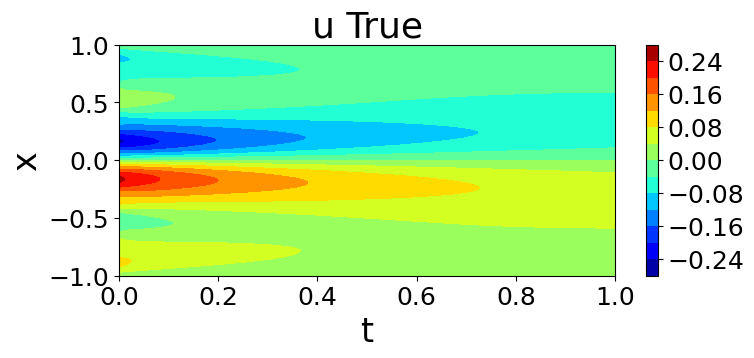

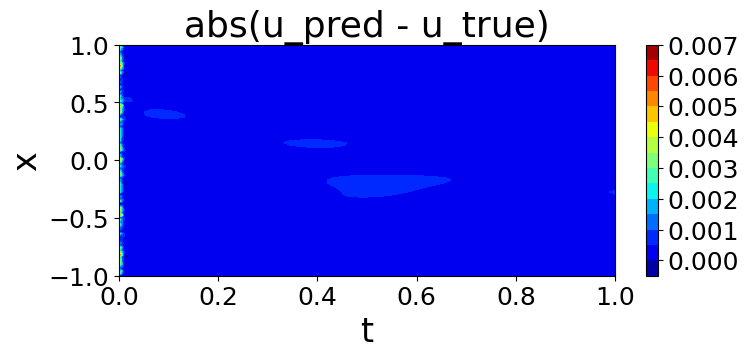

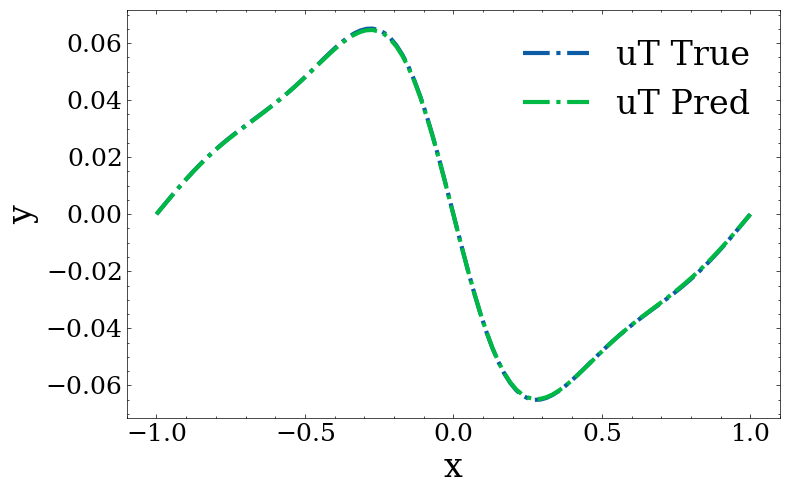

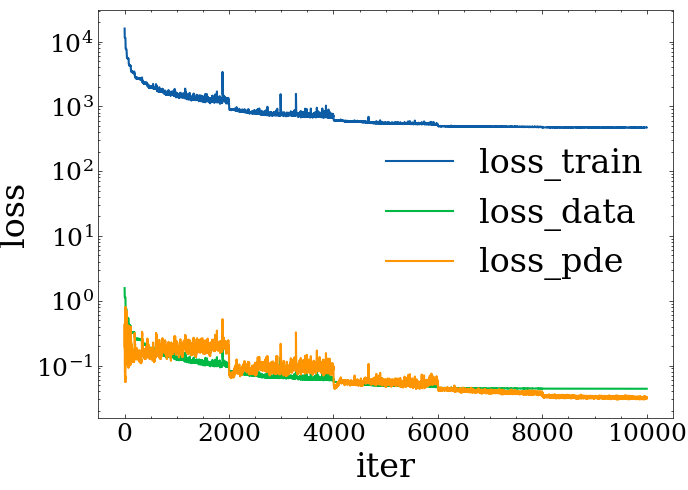

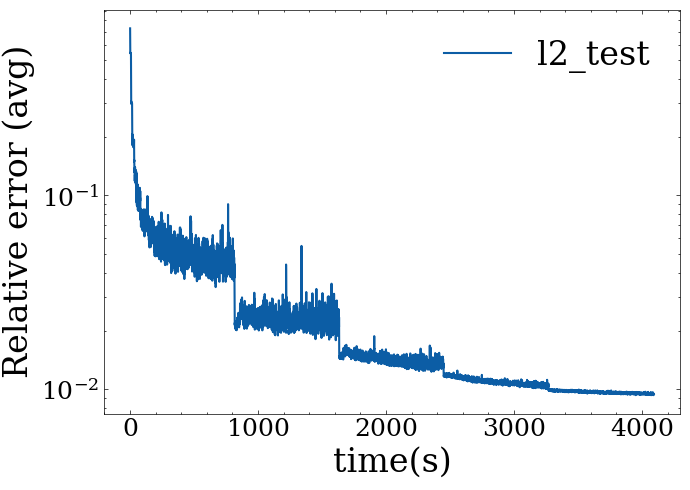

In [5]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent{beta_size}/', name=f'model_dgno_besterror')

########## The prediction of u(x,t)
with torch.no_grad():
    beta_pred = model_trained['enc'](a_test.to(device))
    xt_test = gridxt_test.repeat(u_test.shape[0], 1, 1).to(device)
    #
    u_pred = model_trained['u'](xt_test, beta_pred)
    u_pred = mollifier()(u_pred, xt_test).detach().cpu()
print('The test l2 error for u (avg):', solver.getError(u_pred, u_test))
######################################## The prediction of u(x,t=T)
with torch.no_grad():
    xt_end_test = xt_end.repeat(uT_test.shape[0], 1, 1).to(device)
    uT_pred = model_trained['u'](xt_end_test, beta_pred)
    uT_pred = mollifier()(uT_pred, xt_end_test).detach().cpu()

# # # ########################################
from Utils.PlotFigure import Plot
inx = 0
Plot.show_1dt(gridxt_test, u_pred[inx], title='u True', tT=1.)
Plot.show_1dt(gridxt_test, torch.abs(u_pred[inx]-u_test[inx]), title='abs(u_pred - u_true)', tT=1.)
Plot.show_1d_list(x_test[inx], [uT_test[inx], uT_pred[inx]], ['uT True', 'uT Pred'], lb=-1.)
# #############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_latent{beta_size}/', name='loss_dgno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])